In [44]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

In [45]:
main_df = pd.read_csv('../data/raw/medical_insurance_cost.csv')
main_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [46]:
# Search empty data on columns
null_counts = main_df.isnull().sum()
print(null_counts)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [47]:
duplicated = main_df[main_df.duplicated()]
print(duplicated)

main_df = main_df.drop_duplicates()

     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


In [48]:
# Get each column type and check if there are more than one type per column to unify them
column_types = main_df.dtypes

formatted_types = {
    column: column_types[column].name if column_types[column] != 'bool' else 'boolean' 
    for column in main_df.columns
}

def get_types_per_column(df_columns):
    for column in df_columns:
        column_types = main_df[column].apply(type).unique()
        if len(column_types) > 1:
            type_names = [t.__name__ for t in column_types]
            print(f'{column}: <{type_names}>')
        else:
            print(f'{column}: <{column_types[0].__name__}>')

get_types_per_column(main_df.columns)

age: <int>
sex: <str>
bmi: <float>
children: <int>
smoker: <str>
region: <str>
charges: <float>


Tras observar que no tenemos valores nulos en el dataset y que todas las columnas tienen un tipo único y que se corresponde correctamente con sus datos, se procede a la búsqueda de valores atípicos.

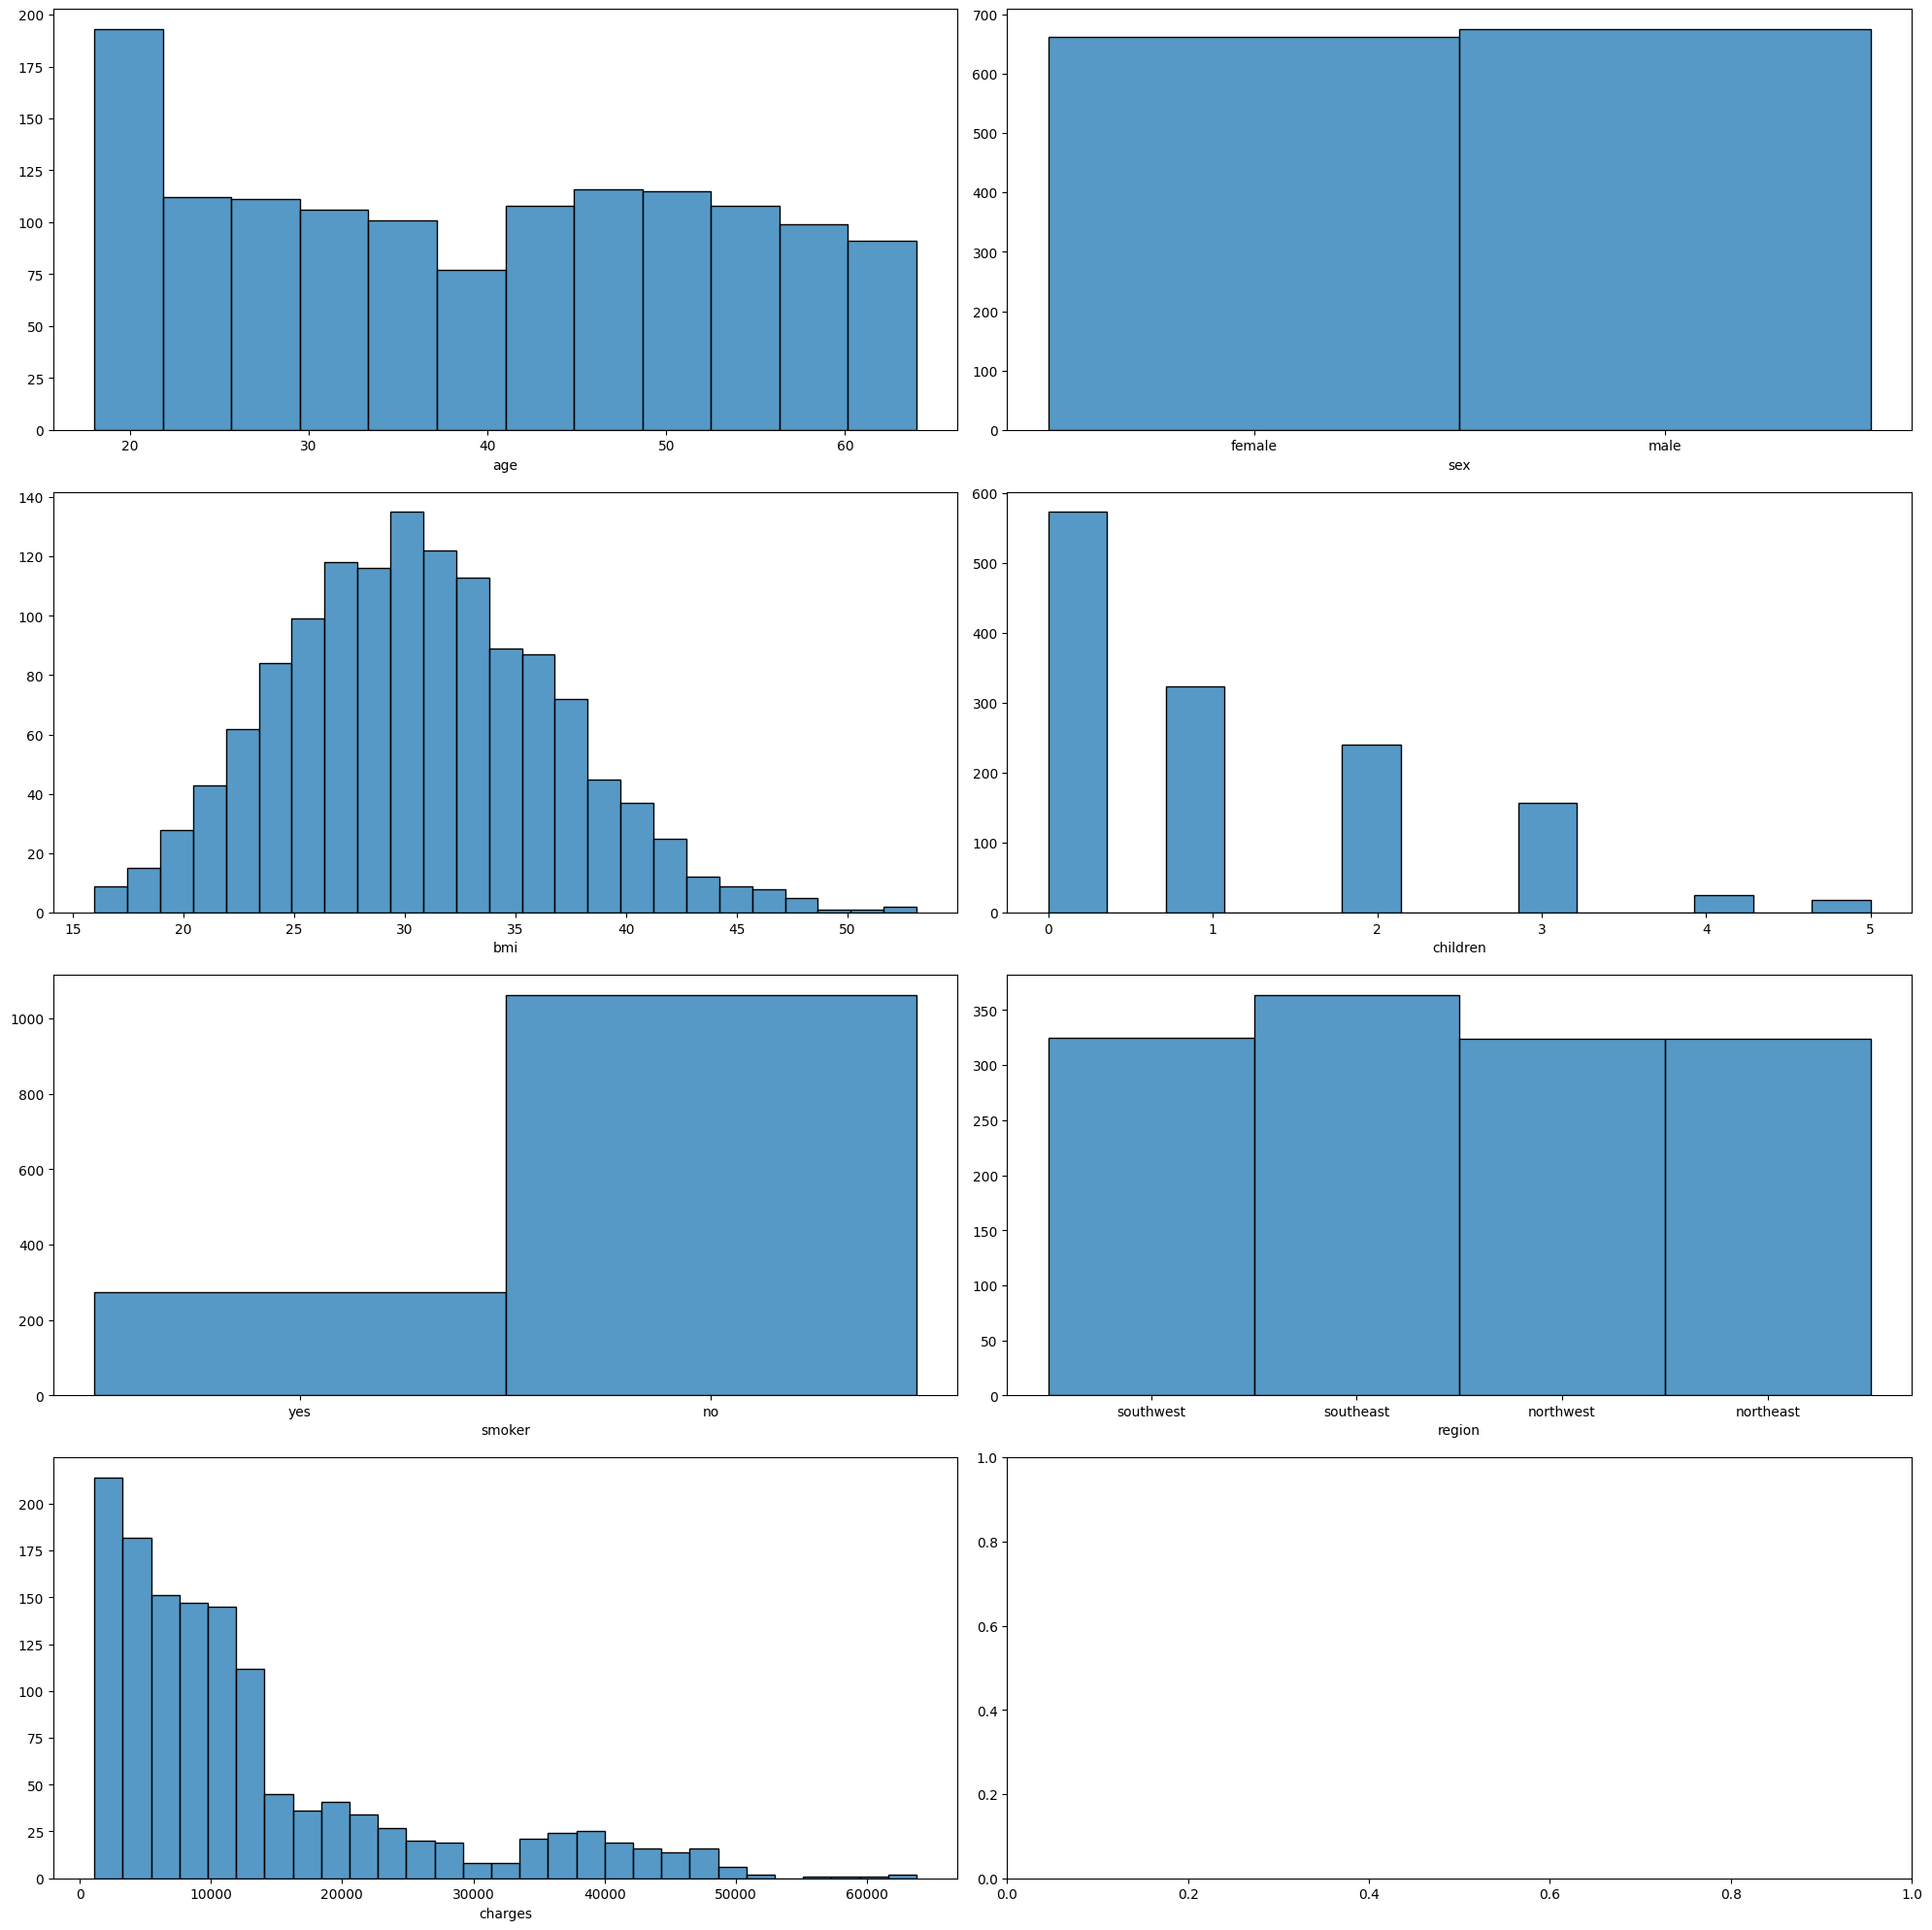

In [49]:
# Graphic analysis
fig, axis = plt.subplots(4, 2, figsize=(20, 20))

sns.histplot(ax=axis[0, 0], data=main_df, x='age').set(ylabel=None)
sns.histplot(ax=axis[0, 1], data=main_df, x='sex').set(ylabel=None)
sns.histplot(ax=axis[1, 0], data=main_df, x='bmi').set(ylabel=None)
sns.histplot(ax=axis[1, 1], data=main_df, x='children').set(ylabel=None)
sns.histplot(ax=axis[2, 0], data=main_df, x='smoker').set(ylabel=None)
sns.histplot(ax=axis[2, 1], data=main_df, x='region').set(ylabel=None)
sns.histplot(ax=axis[3, 0], data=main_df, x='charges').set(ylabel=None)

plt.tight_layout()
plt.show()

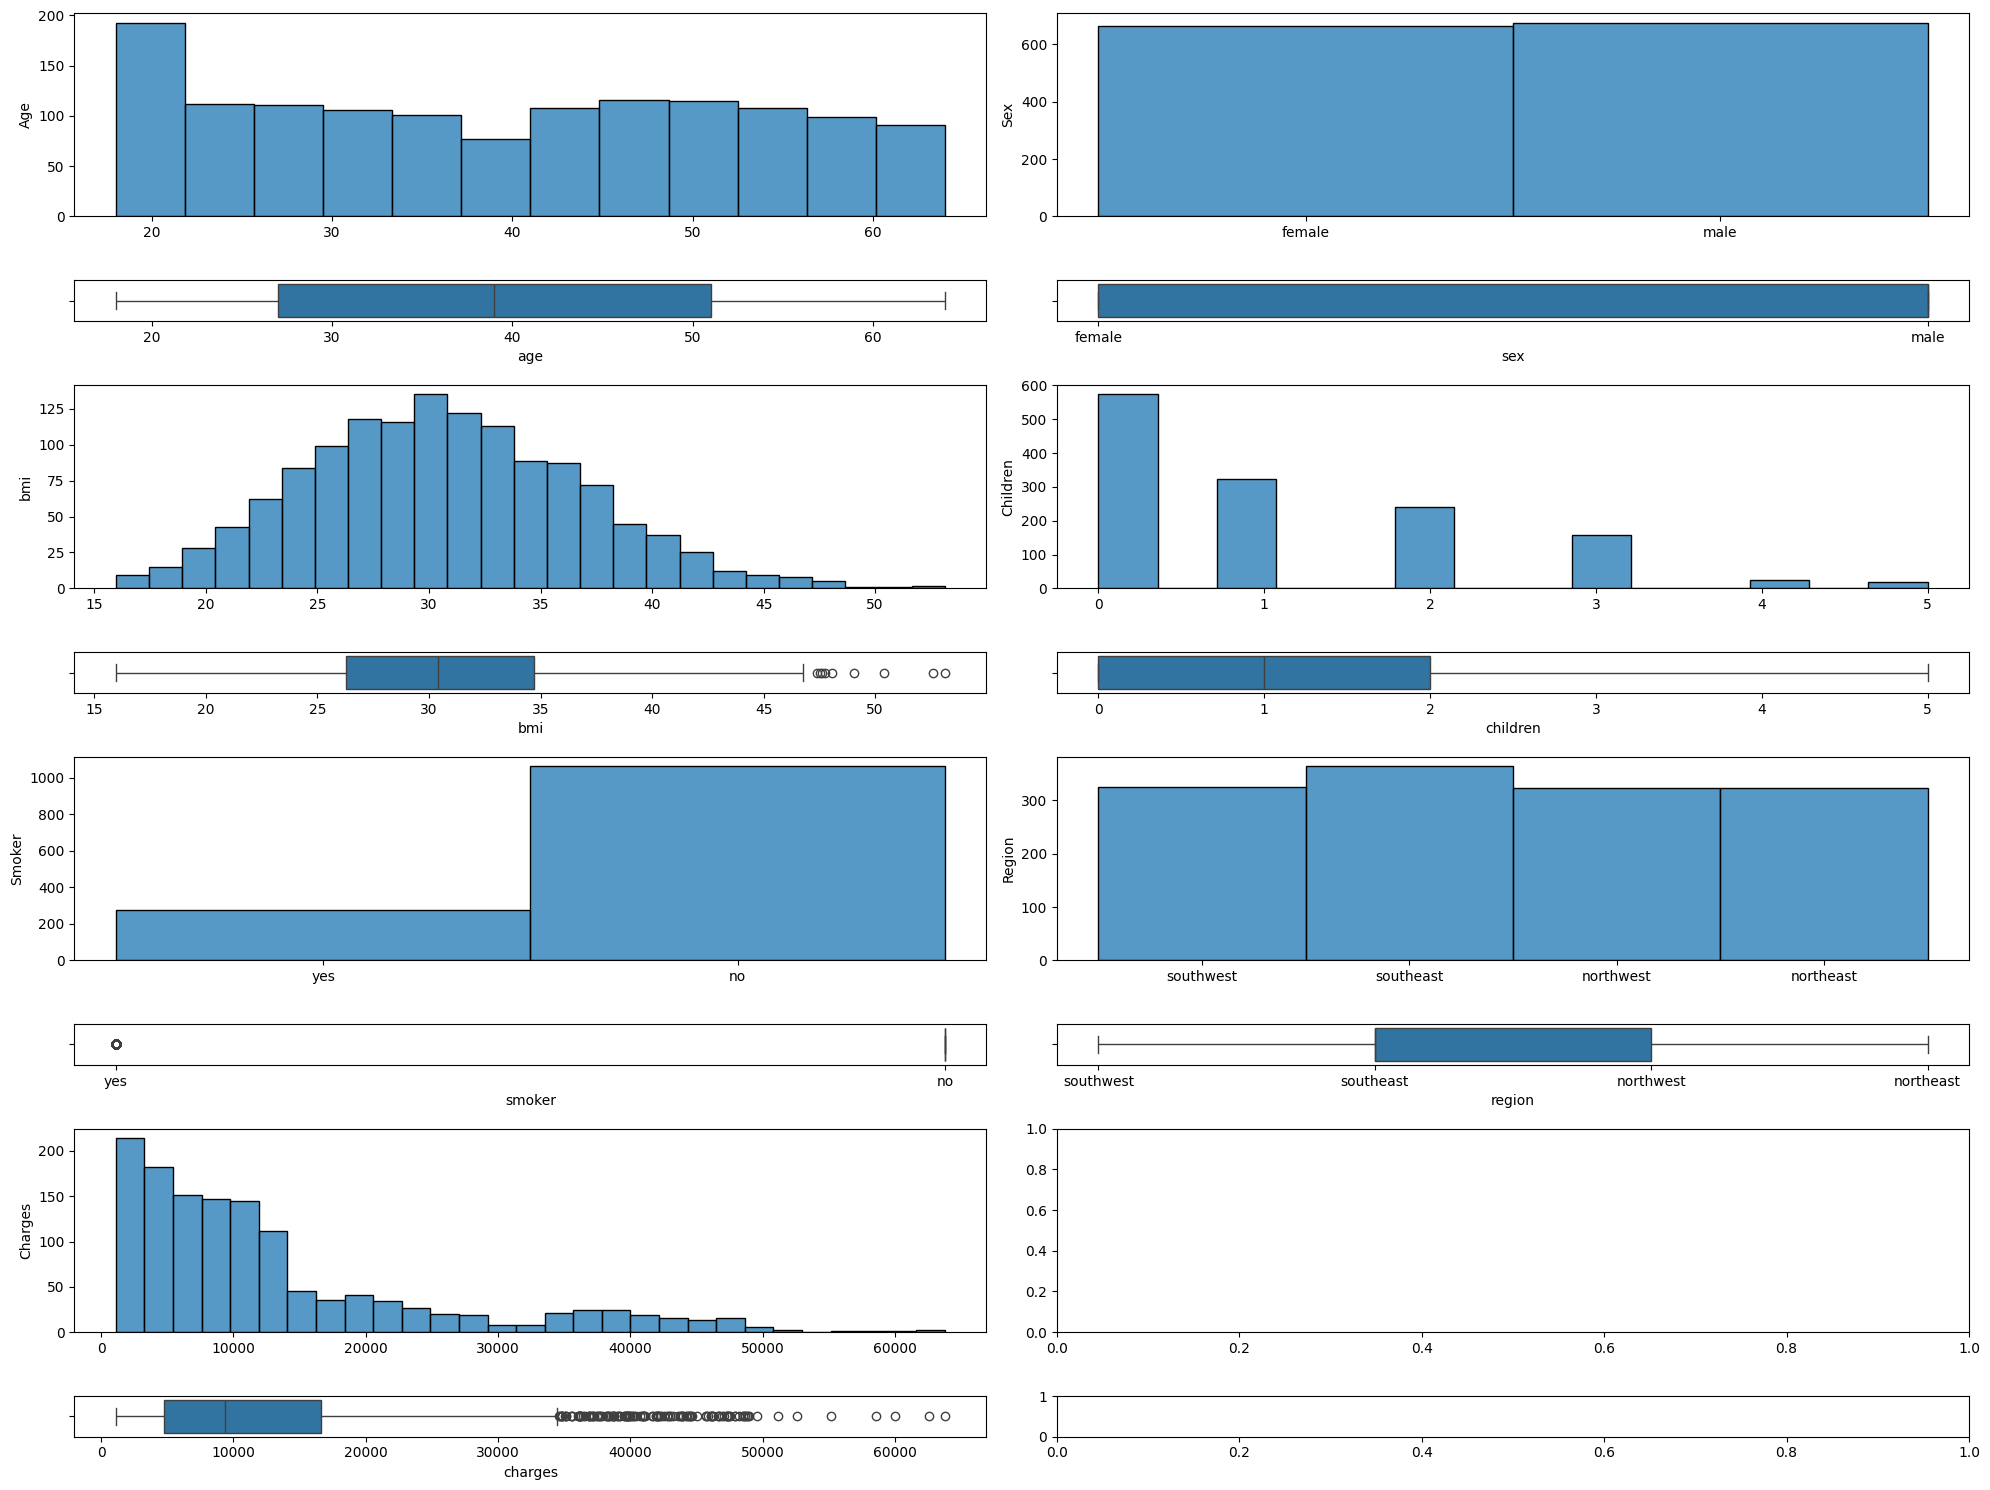

In [50]:
# Check outliers
fig, axis = plt.subplots(8, 2, figsize=(20, 15), gridspec_kw={'height_ratios': [10, 2] * 4})

sns.histplot(ax=axis[0, 0], data=main_df, x="age").set(xlabel=None)
axis[0, 0].set_ylabel('Age')
sns.boxplot(ax=axis[1, 0], data=main_df, x="age")

sns.histplot(ax=axis[0, 1], data=main_df, x="sex").set(xlabel=None)
axis[0, 1].set_ylabel('Sex')
sns.boxplot(ax=axis[1, 1], data=main_df, x="sex")

sns.histplot(ax=axis[2, 0], data=main_df, x="bmi").set(xlabel=None)
axis[2, 0].set_ylabel('bmi')
sns.boxplot(ax=axis[3, 0], data=main_df, x="bmi")

sns.histplot(ax=axis[2, 1], data=main_df, x="children").set(xlabel=None)
axis[2, 1].set_ylabel('Children')
sns.boxplot(ax=axis[3, 1], data=main_df, x="children")

sns.histplot(ax=axis[4, 0], data=main_df, x="smoker").set(xlabel=None)
axis[4, 0].set_ylabel('Smoker')
sns.boxplot(ax=axis[5, 0], data=main_df, x="smoker")

sns.histplot(ax=axis[4, 1], data=main_df, x="region").set(xlabel=None)
axis[4, 1].set_ylabel('Region')
sns.boxplot(ax=axis[5, 1], data=main_df, x="region")

sns.histplot(ax=axis[6, 0], data=main_df, x="charges").set(xlabel=None)
axis[6, 0].set_ylabel('Charges')
sns.boxplot(ax=axis[7, 0], data=main_df, x="charges")

plt.tight_layout()
plt.show()

In [51]:
def get_Q_per_data(column):
    Q1 = main_df[column].quantile(0.25)
    Q3 = main_df[column].quantile(0.75)
    IQR = Q3 - Q1

    quartiles = {
        'severe_lower': Q1 - 3 * IQR,
        'lower': Q1 - 1.5 * IQR,
        'upper': Q1 + 1.5 * IQR,
        'severe_upper': Q1 + 3 * IQR,
    }

    return quartiles

high_charges = main_df[main_df['charges'] >= get_Q_per_data('charges')['severe_upper']]

total_charges = main_df['charges'].count()
high_charges_count = high_charges['charges'].count()

print((high_charges_count / total_charges) * 100)

5.534779356768885


Tras observar los datos podemos apreciar outliers severos principalmente en charges, y dado que suponen aproximadamente un 5% de los datos podemos proceder a eliminarlos para tener información más consistente.

In [52]:
print(f'Shape before remove outliers:\n{main_df.shape}\n')

severe_upper = get_Q_per_data('charges')['severe_upper']
main_df = main_df[main_df['charges'] <= severe_upper]

print(f'Shape after remove outliers:\n{main_df.shape}\n')

Shape before remove outliers:
(1337, 7)

Shape after remove outliers:
(1263, 7)



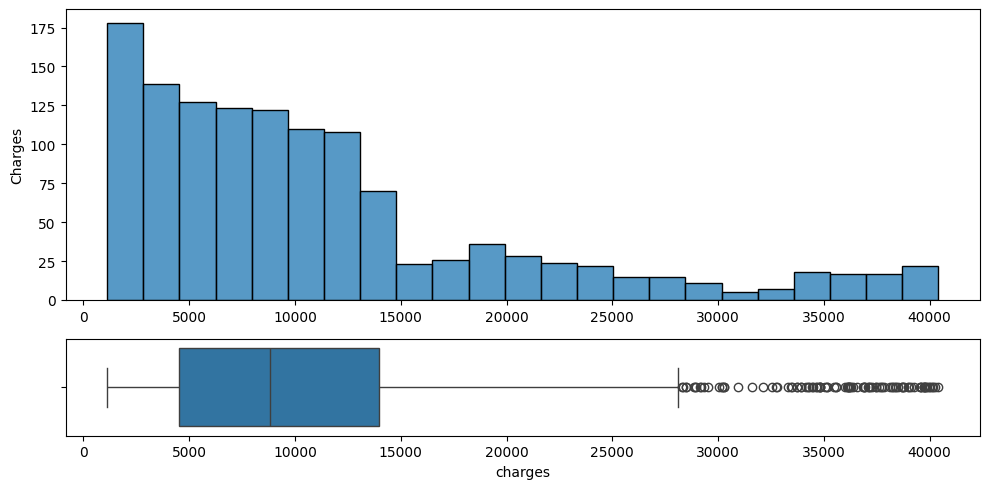

In [53]:
fig, axis = plt.subplots(2, figsize=(10, 5), gridspec_kw={'height_ratios': [3, 1]})

sns.histplot(ax=axis[0], data=main_df, x="charges").set(xlabel=None)
axis[0].set_ylabel('Charges')
sns.boxplot(ax=axis[1], data=main_df, x="charges")

plt.tight_layout()
plt.show()

A continuación pasaremos a hacer un análisis multivariante numérico-numérico. Para ello, ya que tenemos algunas variables categóricas que podemos entender como números, procedemos a transformarlas para su correcto procesamiento.

In [54]:
le = LabelEncoder()

categorical_variables = [
    'sex',
    'smoker',
    'region',
    ]

for each in categorical_variables:
    main_df[each] = le.fit_transform(main_df[each])

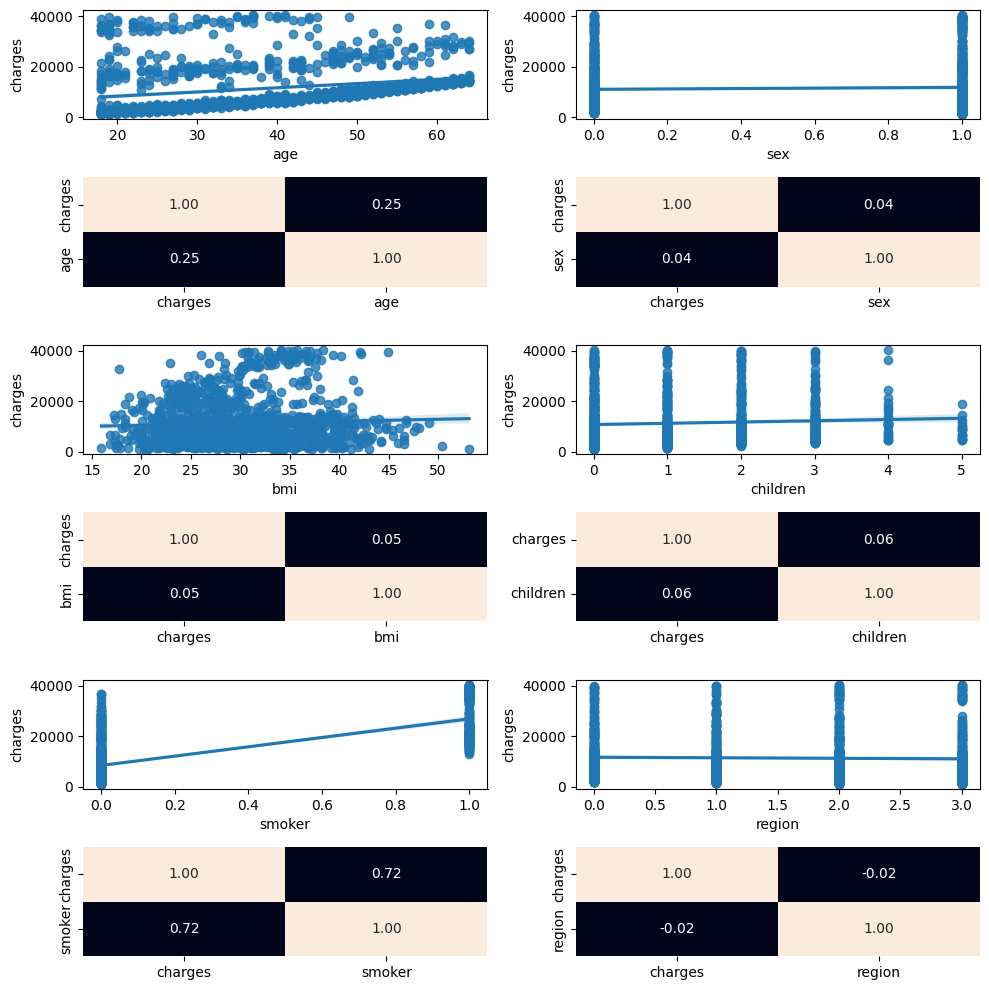

In [55]:
# Numerical-numerical analysis
fig, axis = plt.subplots(6, 2, figsize = (10, 10))

sns.regplot(ax = axis[0, 0], data = main_df, x = "age", y = "charges")
sns.heatmap(main_df[["charges", "age"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)

sns.regplot(ax = axis[0, 1], data = main_df, x = "sex", y = "charges")
sns.heatmap(main_df[["charges", "sex"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1], cbar = False)

sns.regplot(ax = axis[2, 0], data = main_df, x = "bmi", y = "charges")
sns.heatmap(main_df[["charges", "bmi"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 0], cbar = False)

sns.regplot(ax = axis[2, 1], data = main_df, x = "children", y = "charges")
sns.heatmap(main_df[["charges", "children"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 1], cbar = False)

sns.regplot(ax = axis[4, 0], data = main_df, x = "smoker", y = "charges")
sns.heatmap(main_df[["charges", "smoker"]].corr(), annot = True, fmt = ".2f", ax = axis[5, 0], cbar = False)

sns.regplot(ax = axis[4, 1], data = main_df, x = "region", y = "charges")
sns.heatmap(main_df[["charges", "region"]].corr(), annot = True, fmt = ".2f", ax = axis[5, 1], cbar = False)

plt.tight_layout()
plt.show()

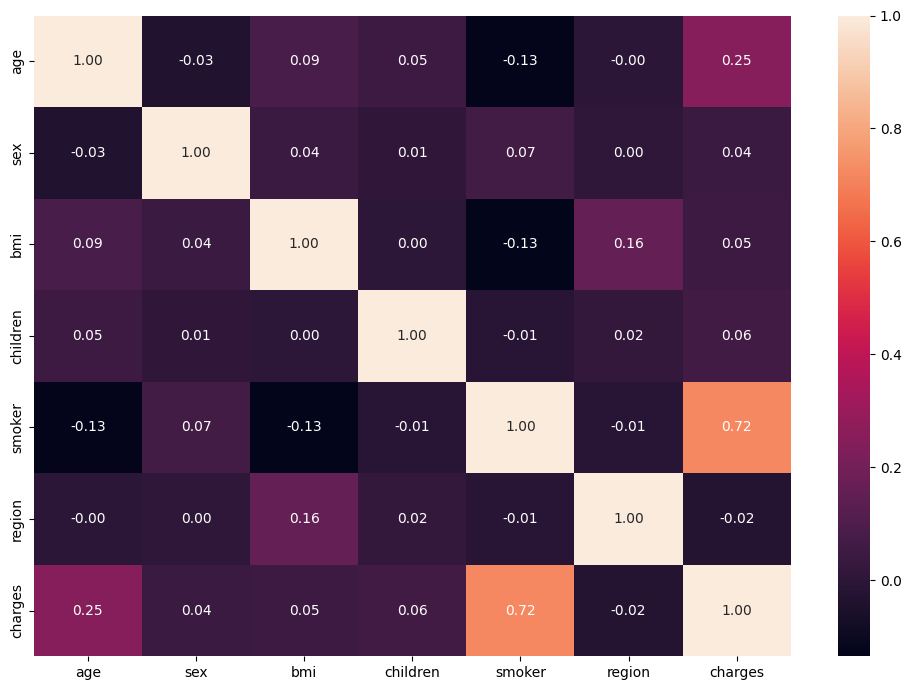

In [59]:
fig, axis = plt.subplots(figsize = (10, 7))

sns.heatmap(main_df[['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']].corr(), annot = True, fmt = ".2f")

plt.tight_layout()

plt.show()

In [57]:
# Descriptive analysis
main_df.describe()

,age,sex,bmi,children,smoker,region,charges
count,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000
mean,38.624703,0.499604,30.302751,1.085511,0.158353,1.512272,11358.960554
std,13.988962,0.500198,5.983349,1.210351,0.365216,1.111658,9343.257020
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,26.000000,0.000000,25.935000,0.000000,0.000000,1.000000,4532.868000
50%,38.000000,0.000000,30.000000,1.000000,0.000000,2.000000,8798.593000
75%,51.000000,1.000000,34.105000,2.000000,0.000000,2.000000,13991.492075
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,40419.019100


In [58]:
# Save clean dataframe into a csv file
main_df.to_csv('../data/raw/clean_df.csv', index=False, encoding='utf-8')